In [13]:
# Notebook complet pour entraîner un modèle CNN avec attention (SE + Spatial Attention)
import os
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers, losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_CLASSES = 6
LR_INIT = 1e-3
LABEL_SMOOTHING = 0.1

merged_train_dir = "../../merged/train"
merged_test_dir  = "../../merged/test"


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    merged_train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    merged_test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 99408 images belonging to 6 classes.
Found 5157 images belonging to 6 classes.


In [ ]:
class SqueezeExciteBlock(layers.Layer):
    def __init__(self, filters, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)
        self.fc1 = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')
        self.fc2 = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')
    def call(self, inputs):
        x = self.gap(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        return inputs * x
    def get_config(self):
        config = super(SqueezeExciteBlock, self).get_config()
        config.update({"filters": self.filters, "ratio": self.ratio})
        return config

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, padding='same',
                                  activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return inputs * attention
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

In [17]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),

    # Bloc 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    SqueezeExciteBlock(filters=32, ratio=16),
    SpatialAttention(kernel_size=7),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Bloc 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    SqueezeExciteBlock(filters=64, ratio=16),
    SpatialAttention(kernel_size=7),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Bloc 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    SqueezeExciteBlock(filters=128, ratio=16),
    SpatialAttention(kernel_size=7),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Bloc 4
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    # SqueezeExciteBlock(filters=256, ratio=16),
    # SpatialAttention(kernel_size=7),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])



In [ ]:
loss_fn = losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR_INIT),
    loss=loss_fn,
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Environ 40 min
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
3107/3107 [==============================] - 335s 107ms/step - loss: 2.3102 - accuracy: 0.3320 - val_loss: 1.6978 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 2/50
3107/3107 [==============================] - 40s 13ms/step - loss: 1.5866 - accuracy: 0.4951 - val_loss: 1.5782 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 3/50
3107/3107 [==============================] - 41s 13ms/step - loss: 1.5003 - accuracy: 0.5375 - val_loss: 1.4965 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 4/50
3107/3107 [==============================] - 41s 13ms/step - loss: 1.4487 - accuracy: 0.5625 - val_loss: 1.4242 - val_accuracy: 0.5693 - lr: 0.0010
Epoch 5/50
3107/3107 [==============================] - 41s 13ms/step - loss: 1.4101 - accuracy: 0.5798 - val_loss: 1.4150 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 6/50
3107/3107 [==============================] - 41s 13ms/step - loss: 1.3850 - accuracy: 0.5923 - val_loss: 1.3539 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 7/50
3107/3107 [======================

In [19]:
model.save("facial_expression_model.h5")

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

162/162 [==============================] - 2s 9ms/step - loss: 0.9659 - accuracy: 0.7675
Test Accuracy: 0.77


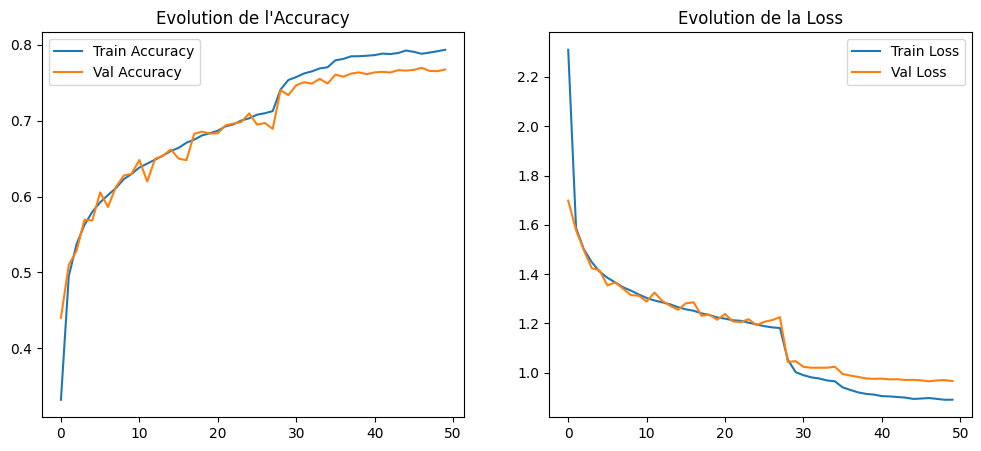

In [21]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Evolution de l'Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Evolution de la Loss")
plt.legend()

plt.show()


1/1 [==============================] - 0s 172ms/step


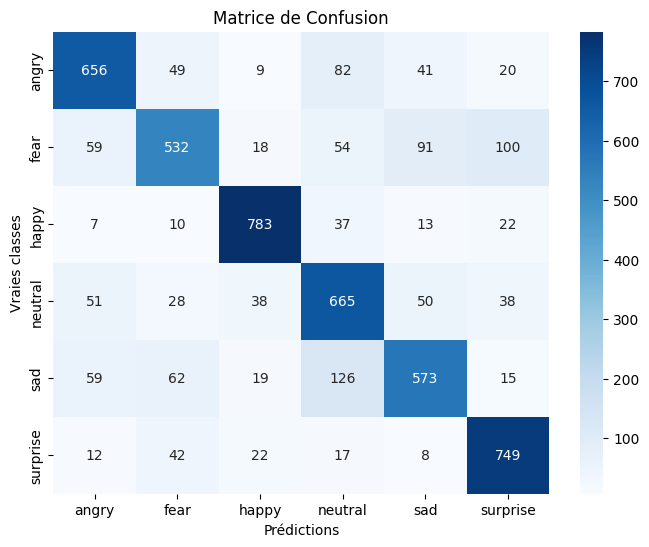

Classification Report:
              precision    recall  f1-score   support

       angry       0.78      0.77      0.77       857
        fear       0.74      0.62      0.67       854
       happy       0.88      0.90      0.89       872
     neutral       0.68      0.76      0.72       870
         sad       0.74      0.67      0.70       854
    surprise       0.79      0.88      0.84       850

    accuracy                           0.77      5157
   macro avg       0.77      0.77      0.77      5157
weighted avg       0.77      0.77      0.77      5157



In [ ]:
y_true = []
y_pred = []

for batch in val_generator:
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1))                   # Labels réels
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))    # Prédictions

    if len(y_true) >= val_generator.samples:
        break

class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [41]:
class SqueezeExciteBlock(tf.keras.layers.Layer):
    def __init__(self, filters, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio
        self.gap = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.fc1 = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')
        self.fc2 = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')
    def call(self, inputs):
        x = self.gap(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        return inputs * x
    def get_config(self):
        config = super(SqueezeExciteBlock, self).get_config()
        config.update({"filters": self.filters, "ratio": self.ratio})
        return config

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(1, kernel_size=kernel_size, padding='same',
                                           activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return inputs * attention
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config


In [43]:
model = tf.keras.models.load_model(
    "../save/scratch_merged_final_77.h5",
    custom_objects={
        "SqueezeExciteBlock": SqueezeExciteBlock,
        "SpatialAttention": SpatialAttention
    }
)


In [ ]:
haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_path)

def predict_expression(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Erreur lors de la lecture de l'image")
        return

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)
    
    if len(faces) == 0:
        print("Aucun visage détecté, utilisation de l'image complète.")
        face_cropped = img_gray
    else:
        faces = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)
        (x, y, w, h) = faces[0]
        face_cropped = img_gray[y:y+h, x:x+w]
    
    face_resized = cv2.resize(face_cropped, (64, 64))
    face_normalized = face_resized.astype("float32") / 255.0
    face_normalized = np.expand_dims(face_normalized, axis=-1) 
    input_img = np.expand_dims(face_normalized, axis=0)   
    
    pred = model.predict(input_img)
    pred_class = np.argmax(pred, axis=1)[0]
    
    label_map = {0: "angry", 1: "fear", 2: "happy", 3: "neutral", 4: "sad", 5: "surprise"}
    predicted_label = label_map.get(pred_class, "Unknown")
    
    plt.figure(figsize=(3,3))
    plt.imshow(face_resized, cmap="gray")
    plt.title(f"Predicted Expression: {predicted_label}")
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 14ms/step


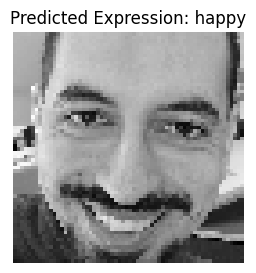

In [73]:
predict_expression("../../validation/happy5.jpg")